In [6]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential 
from keras.layers import Dense,Dropout,Flatten, BatchNormalization,GlobalAveragePooling2D
from tensorflow.python.lib.io import file_io
#from keras.layers import Conv2D, Maxpooling2D
from keras.applications import VGG19# keras_vggface includes RESNET50, VGG16, SENET50
from keras_vggface.vggface import VGGFace#library edited get_source added.
from tensorflow.keras.optimizers.legacy import Adam

import os 
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
from tensorflow.keras import layers, Model
from keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import load_model
#from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K
from keras.utils import plot_model
from sklearn.metrics import *
from tensorflow.keras import Model
import skimage
from skimage.transform import rescale, resize

import pydot

In [7]:
from tensorflow.python.client import device_lib 
def get_available_devices () :
    local_device_protos = device_lib.list_local_devices ()
    return [x.name for x in local_device_protos]
print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [8]:
import tensorflow as tf
print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.print(physical_devices)

2.9.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
train_data_dir ="Archive/Train" #FER2013 dataset train set
validation_data_dir ="Archive/test-public" #fer2013 datset test set

In [10]:
model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3), pooling='avg')


base_input = model.layers[0].input
base_output = model.layers[-3].output
model = Model(base_input, base_output)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [11]:
x = GlobalAveragePooling2D()(base_output)
#x = Dense(4096, activation='relu', name='fc6')(x)
#x = Dropout(DROPOUT_RATE)(x)#0.5 drop out
#x = Dense(4096, activation='relu', name='fc7')(x)

#model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)
#print(vgg_notop.get_layer('pool5').trainable)

out = Dense(7, activation='softmax', name='classifier')(x)#7 classes in FER2013

model = Model(base_input, out)

#OPTİMİZER
model.summary()

#optim = keras.optimizers.Adam(learning_rate=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optim = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


sgd = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
filepath="vgg16_vggface_weights_improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1)

callbacks_list = [checkpoint, reduce_lr, early_stop]
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

In [12]:
print(model.summary())


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

In [13]:
def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,#multiply the data by the value provided (after applying all other transformations).
            #Khanzada neden rescale yapıldığından bahsedilmiyor.
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=20, 
                            width_shift_range=0.1, #float: fraction of total width, if < 1, or pixels if >= 1.
                            height_shift_range=0.1,
                            zoom_range=0.2,#.2 7.makale
                            horizontal_flip=True) #vertical flip gives unrelated results 
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            color_mode='rgb', #Grayscale changed to RGB to fit the model(error 1 vs 3 while fit_generator) 
            target_size=(224, 224), # why did they use 197x197? (try with 224x224 and 48x48) 
            #48x48 makes images blurry, 224x224 lost resolution, around 200 best fit.  
            #The network breaks if we use a width or height lesser than 197 as the dimension becomes smaller 
            #than the applied convolution
#***        #API'a bak, keras rgbyi alıp dublicate mi yapıyor?Ne yapıyor? 48x48 ---> 197x197 yaparken hangi matematiksel fonksiyonu kullanıyor?
            #image size değiştirilirken ne yapıyor?(Matematiksel)
            shuffle = True,
            class_mode='categorical',
            batch_size=32)

target_size: Tuple of integers `(height, width)`,
               default: `(256, 256)`.
              The dimensions to which all images found will be resized.
https://stackoverflow.com/questions/50442970/keras-flow-from-directory-function-target-size-parameter
default nearest approch -- https://petapixel.com/2016/09/08/math-behind-digital-photo-resizing-works/
fill_mode: One of {"constant", "nearest", "reflect" or "wrap"}.
            Default is 'nearest'.
            Points outside the boundaries of the input are filled
            according to the given mode:
            - 'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
            - 'nearest':  aaaaaaaa|abcd|dddddddd
            - 'reflect':  abcddcba|abcd|dcbaabcd
            - 'wrap':  abcdabcd|abcd|abcdabcd
Stackoverflow: https://stackoverflow.com/questions/65457708/how-are-image-resize-in-imagedatagenerator

In [14]:
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
#tf.keras.preprocessing.image.ImageDataGenerator(
#   featurewise_center=False, featurewise_center	Boolean. Set input mean to 0 over the dataset, feature-wise.
#   samplewise_center=False, Boolean. Set each sample mean to 0.
#   featurewise_std_normalization=False, Boolean. Divide inputs by std of the dataset, feature-wise.
#   samplewise_std_normalization=False, Boolean. Divide each input by its std.
#   zca_whitening=False, Boolean. Apply ZCA whitening.
#   zca_epsilon=1e-06, epsilon for ZCA whitening. Default is 1e-6.
#   rotation_range=0, Int. Degree range for random rotations.
#   width_shift_range=0.0,
#   height_shift_range=0.0,
#   brightness_range=None,
#   shear_range=0.0,
#   zoom_range=0.0,
#   channel_shift_range=0.0,
#   fill_mode='nearest',
#   cval=0.0,
#   horizontal_flip=False,
#   vertical_flip=False,
#   rescale=None,
#   preprocessing_function=None,
#   data_format=None,
#   validation_split=0.0,
#   interpolation_order=1,
#   dtype=None
#)
#flow_from_directory(
#   directory,
#   target_size=(256, 256),
#   color_mode='rgb', "grayscale", "rgb", "rgba" --> 1,3,4
#   classes=None,
#   class_mode='categorical', "categorical" will be 2D one-hot encoded labels,
#   batch_size=32,
#   shuffle=True,
#   seed=None,
#   save_to_dir=None,
#   save_prefix='',
#   save_format='png',
#   follow_links=False,
#   subset=None,
#   interpolation='nearest',
#   keep_aspect_ratio=False
#)
#0.5 image pixels drop yapılacak --- (7. makaledeki verilerin bazısının silinmesi implemente edilecek.)

In [15]:
Train_Data_Generator = get_datagen('Archive/Train', True)# yüzdelik nerede yazıyordu?
Validation_Data_Generator = get_datagen('Archive/test-public')
test_datagen  = get_datagen('Archive/test-private')#train-test-validation splt nasıl yapıldı?
#random mı? ****** Detaylandır.


Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


Indirilen csv file içerisinde 'usage' altında training, privateTest ve publicTest olarak işaretlenmiş.
Labellarına göre 3 dosyaya ayrılıp kaydedildi.  

In [16]:
batch_size=32
history = model.fit(
    Train_Data_Generator,
    validation_data = Validation_Data_Generator, 
    steps_per_epoch=28709// batch_size,
    validation_steps=3509 // batch_size,
    shuffle=True,
    epochs=50,
    callbacks=[callbacks_list],
) 

Epoch 1/50
897/897 [==============================] - ETA: 0s - loss: 1.4793 - accuracy: 0.4281
Epoch 1: val_accuracy improved from -inf to 0.57397, saving model to vgg16_vggface_weights_improvement-01-0.57.hdf5
897/897 [==============================] - 529s 590ms/step - loss: 1.4793 - accuracy: 0.4281 - val_loss: 1.1329 - val_accuracy: 0.5740 - lr: 0.0010
Epoch 2/50
897/897 [==============================] - ETA: 0s - loss: 1.0980 - accuracy: 0.5941
Epoch 2: val_accuracy improved from 0.57397 to 0.61984, saving model to vgg16_vggface_weights_improvement-02-0.62.hdf5
897/897 [==============================] - 528s 589ms/step - loss: 1.0980 - accuracy: 0.5941 - val_loss: 1.0255 - val_accuracy: 0.6198 - lr: 0.0010
Epoch 3/50
897/897 [==============================] - ETA: 0s - loss: 1.0109 - accuracy: 0.6244
Epoch 3: val_accuracy improved from 0.61984 to 0.63102, saving model to vgg16_vggface_weights_improvement-03-0.63.hdf5
897/897 [==============================] - 525s 585ms/step - l

Epoch 26/50
897/897 [==============================] - ETA: 0s - loss: 0.3533 - accuracy: 0.8717
Epoch 26: val_accuracy improved from 0.71130 to 0.71302, saving model to vgg16_vggface_weights_improvement-26-0.71.hdf5
897/897 [==============================] - 529s 589ms/step - loss: 0.3533 - accuracy: 0.8717 - val_loss: 1.0971 - val_accuracy: 0.7130 - lr: 2.0000e-04
Epoch 27/50
897/897 [==============================] - ETA: 0s - loss: 0.3435 - accuracy: 0.8770
Epoch 27: val_accuracy did not improve from 0.71302
897/897 [==============================] - 529s 590ms/step - loss: 0.3435 - accuracy: 0.8770 - val_loss: 1.1420 - val_accuracy: 0.7007 - lr: 2.0000e-04
Epoch 28/50
897/897 [==============================] - ETA: 0s - loss: 0.3284 - accuracy: 0.8805
Epoch 28: val_accuracy did not improve from 0.71302
897/897 [==============================] - 530s 590ms/step - loss: 0.3284 - accuracy: 0.8805 - val_loss: 1.1534 - val_accuracy: 0.7061 - lr: 2.0000e-04
Epoch 29/50
897/897 [========

In [17]:
# Load the weights of the best validation accuracy model
model.load_weights('vgg16_vggface_weights_improvement-32-0.71.hdf5') # edit iwth my path to file

# Compile the model with the same optimizer, loss function, and metrics as during training
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(Validation_Data_Generator)
print('Validation loss:', val_loss)
print('Validation accuracy:', val_accuracy)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_datagen)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

113/113 [==============================] - 17s 151ms/step - loss: 1.1999 - accuracy: 0.7127
Validation loss: 1.1999163627624512
Validation accuracy: 0.7127333879470825
113/113 [==============================] - 18s 163ms/step - loss: 1.1060 - accuracy: 0.7144
Test loss: 1.1060001850128174
Test accuracy: 0.7144051790237427


In [18]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_datagen, 3509 // batch_size)
print('test loss, test accuracy:', results_test)


# Evaluate on test data


<ipython-input-18-5bae5064a529>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  results_test = model.evaluate_generator(test_datagen, 3509 // batch_size)


test loss, test accuracy: [1.1072932481765747, 0.7138761878013611]


In [19]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate_generator(Validation_Data_Generator, 3509 // batch_size)
print('validation loss, validation accuracy:', results_dev)


# Evaluate on dev data


<ipython-input-19-03599d3dc802>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  results_dev = model.evaluate_generator(Validation_Data_Generator, 3509 // batch_size)


validation loss, validation accuracy: [1.2017879486083984, 0.7121559977531433]


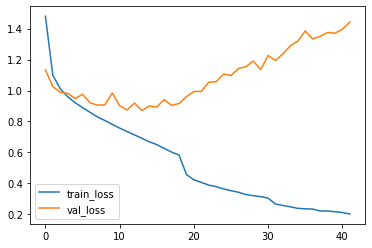

In [20]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
#

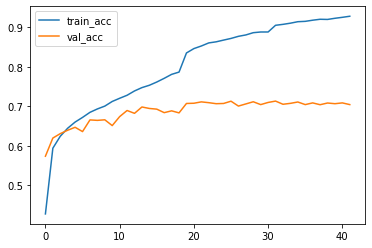

In [21]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
#save best true -- en iyi modeli saklamış olsun. (best validation acc)

In [22]:
class_labels = ['Angry','Disgust','Fear','Happy','Neutral','Disgust','Sad']
img, label = Train_Data_Generator.__next__()

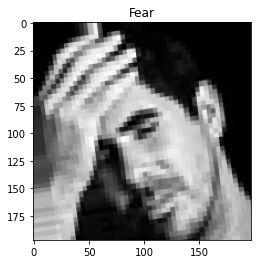

In [83]:
import random

i = random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

In [85]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]
model.save('/Users/fulyayenilmez/cs230-fer-master/my_models/' + 'VGG16' + epoch_str + test_acc + '.h5')